## Challenge: A deep dive into Dialogue Act Recognition
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

**TODO List (after first meeting)**:
- Test multi-label classification algorithms (think about other possibilities)
- ~~On removing punctuation in tokenization: if it relates to emotion recognition -> exclamations could be relevant~~
- Frequency -> if appears too much it might also be redundant (don't provide content) (look into stop word elimination in python)
- <unk> token -> look into other solutions?
- for single utterances: could also try decision trees, support vector based, Naive bayes , or Hidden Markov Model (HMM) (last 2 mentioned in paper)
- ~~feel free to test your approach with whole dataset (study size vs model performance tradeoff)~~
- consider how to represent the utterance, might influence classification:
    - see in similar papers how they represent utterance
    - take a look at paper: "A Comprehensive Survey of Sentence Representations: From the BERT Epoch to the CHATGPT Era and Beyond"
        see if it's easy to apply (if you find code) how does representation influence the final result
- visualize confusion matrix: true vs predicted classes and see where the classifier makes mistakes
- Own idea (chatGPT): provide speaker info alongside utterance instead of prepending it to sentence (e.g. give Neural Net 0 for USER, 1 for SYSTEM, and as second argument the utterance)


In [12]:
USING_COLAB = False
if USING_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

"The Schema-Guided Dialogue (SGD) dataset consists of over 20k annotated multi-domain, task-oriented conversations between a human and a virtual assistant" (https://github.com/google-research-datasets/dstc8-schema-guided-dialogue) It pertains to different domains like banking and weather. In addition to a training and test set, there is also a crowdfunded variant dataset (SGD-X) that can be used to test a model's generalization capabilities to real-world settings.  What's interesting for this project is the dialogue act annotations, which are defined for both system and user. Some possible values include: INFORM, REQUEST, CONFIRM. A complete list can be found on the dataset's github README.md file.

In [13]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import torch
import pandas as pd
import json
import pickle
import torch.utils.data
from tqdm import tqdm
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import re

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Only need to run this code block once, to get a properly formatted json file for test and train set

# train_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TrainSet.json')
# test_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TestSet.json')

# def format_json(path):
#     # For readability purposes, ensure proper structure in the train/test set files
#     with open(path, "r") as f:
#         data = json.load(f)

#     with open(path.replace(".json", "_formatted.json"), "w") as f:
#         json.dump(data, f, indent=4, ensure_ascii=False)

# format_json(train_path)
# format_json(test_path)

In [15]:
if USING_COLAB:
  path_to_dataset = os.path.join(os.getcwd(), "drive", "MyDrive", "Current Trends VUB", 'SGD Dataset')
else:
  path_to_dataset = os.path.join(os.getcwd(), 'SGD Dataset')
path_to_train = os.path.join(path_to_dataset, "TrainSet.json")
path_to_test = os.path.join(path_to_dataset, "TestSet.json")

### Implementation 1: Simple RNN

For the first implementation we'll train a simple RNN and LSTM on the utterances of this dataset, note that this is an utterance level model, trained on a (small) subset of the whole dataset. (TODO: might be interesting to compare with the whole dataset). At inference time the user can then input an utterance and have the system return a dialogue act predicted by the neural network. The code is based on WPOs from the course "Deep Learning" of the master applied computer science at VUB, where it was used in a toy dataset for sentiment analysis and could serve as a benchmark to compare our future models with.

#### Preprocessing
The preprocessing step involves extracting all utterances from the.json files, together with their dialogue acts, which will be used as "labels" in our prediction task. In addition to this, the speaker can be USER or SYSTEM, this information will be encoded in a separate token.

In [16]:
EOD = "<eod>" # End of dialogue token

In [17]:
def extract_turn_data(file_path):
    all_data = []
    with open(file_path, 'r') as f:
        data = json.load(f)
        for dialogue in data:
            for turn in dialogue['turns']:
                all_data.append({
                    'speaker': turn['speaker'],
                    'utterance': turn['utterance'],
                    'act': turn["dialogue_act"]
                })
            all_data[-1]['utterance'] += f" {EOD}" # Add an End Of Dialogue marker at the end of last utterance in turn
    return all_data

extracted_train = extract_turn_data(path_to_train)
extracted_test = extract_turn_data(path_to_test)

for i in range(22, 25):
    print(extracted_train[i])

{'speaker': 'USER', 'utterance': 'I appreciate it very much. That would be all.', 'act': 'USER_THANK_YOU|USER_GOODBYE'}
{'speaker': 'SYSTEM', 'utterance': 'Have a good time! <eod>', 'act': 'SYSTEM_GOODBYE'}
{'speaker': 'USER', 'utterance': 'Hi i need a help, i am very hungry, I am looking for a restaurant', 'act': 'USER_INFORM_INTENT'}


In [18]:
acts = list(set([data['act'] for data in extracted_train] + [data['act'] for data in extracted_test]))

acts_labels = {act : i for i, act in enumerate(acts)}
inv_acts_labels = {v: k for k, v in acts_labels.items()}

# Modified code for processing turns
label_train = [ acts_labels[turn['act']] for turn in extracted_train ]
label_test = [ acts_labels[turn['act']] for turn in extracted_test ]

In [19]:
print(acts_labels, label_train[:5])

{'USER_NEGATE|USER_THANK_YOU': 0, 'SYSTEM_OFFER': 1, 'USER_NEGATE|USER_GOODBYE': 2, 'USER_INFORM_INTENT|USER_NEGATE_INTENT': 3, 'USER_THANK_YOU|USER_GOODBYE': 4, 'USER_INFORM_INTENT|USER_SELECT': 5, 'SYSTEM_OFFER|SYSTEM_INFORM_COUNT': 6, 'SYSTEM_OFFER_INTENT': 7, 'USER_NEGATE_INTENT|USER_GOODBYE': 8, 'USER_REQUEST_ALTS': 9, 'SYSTEM_REQ_MORE': 10, 'USER_AFFIRM_INTENT': 11, 'SYSTEM_GOODBYE': 12, 'SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 13, 'SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS': 14, 'SYSTEM_INFORM': 15, 'USER_INFORM|USER_NEGATE': 16, 'USER_NEGATE_INTENT': 17, 'USER_REQUEST': 18, 'USER_THANK_YOU': 19, 'SYSTEM_CONFIRM': 20, 'SYSTEM_REQUEST': 21, 'USER_NEGATE': 22, 'USER_REQUEST|USER_AFFIRM': 23, 'USER_INFORM': 24, 'USER_INFORM|USER_REQUEST_ALTS': 25, 'USER_AFFIRM_INTENT|USER_INFORM': 26, 'USER_INFORM_INTENT': 27, 'USER_INFORM|USER_INFORM_INTENT': 28, 'USER_INFORM|USER_INFORM_INTENT|USER_NEGATE_INTENT': 29, 'SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 30, 'USER_SELECT': 31, 'USER_AFFIRM'

In [20]:
def clean_utterances(extracted_turns):
    speakers = []
    utterances = []
    
    for data in extracted_turns:
        utterance = data['utterance'].lower()

        # Replace monetary values: "$23.53", "$1,000", "$500"
        utterance = re.sub(r'\$\d+(?:,\d{3})*(?:\.\d{2})?', '<price>', utterance)

        # Replace all remaining numbers with <number>
        utterance = re.sub(r'\b\d+\b', '<number>', utterance)

        # Separate "?" from words (turns "hello?" into "hello ?")
        # such that it can become it's own token and maybe help the model recognize "requests"
        utterance = re.sub(r'(\w+)\?', r'\1 ?', utterance)

        # Remove unwanted characters
        chars_to_erase = ['.', ',', '!', '$']
        for char in chars_to_erase:
            utterance = utterance.replace(char, '')

        utterances.append(utterance)
        if data['speaker'] == 'USER':
            speakers.append(0)
        elif data['speaker'] == 'SYSTEM':
            speakers.append(1)
        else:
            raise ValueError(f"Unknown speaker: {data['speaker']}, expected USER or SYSTEM")
    
    return speakers, utterances


In [21]:
speakers_train, utterances_train = clean_utterances(extracted_train)
speakers_test, utterances_test = clean_utterances(extracted_test)

In [22]:
print(len(speakers_train), len(utterances_train), len(label_train))
print(len(speakers_test), len(utterances_test), len(label_test))
print(list(set(speakers_train)))
# Sanity check
assert len(speakers_train) == len(utterances_train) == len(label_train), "Lengths of speakers, utterances and labels do not match"

82588 82588 82588
16850 16850 16850
[0, 1]


In [23]:
word_freq = Counter()
for utterance in utterances_train:
    utterance_words = utterance.split()
    word_freq.update(utterance_words)

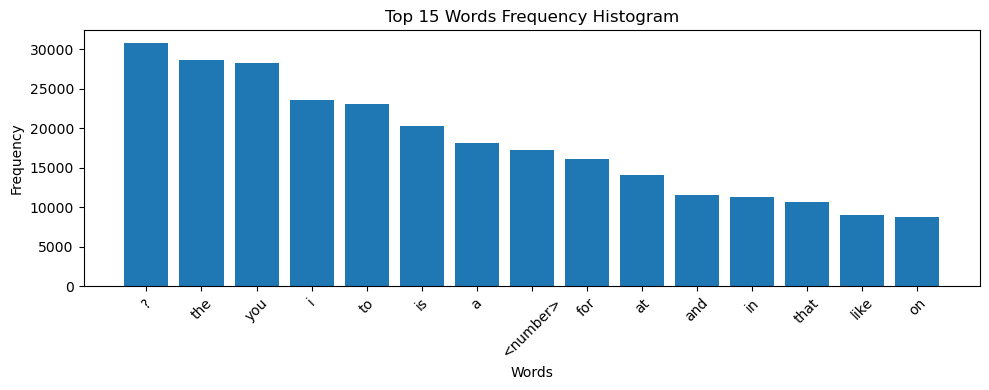

In [24]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [25]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print(f"Total words are: {len(word_map)}")

Total words are: 2704


In [26]:
def encode_text(utterances, max_len):
    """
    Assign a numerical value (0 to len(word_map)) to each word in the
    utterance while handling special tokens.
    """
    encoded_texts = []
    
    for utterance in utterances:
        utterance_words = utterance.lower().split()
        is_last_utterance = utterance_words[-1] == EOD.lower()
        adjusted_max_len = max_len - (3 if is_last_utterance else 2)  # Adjust for special tokens
        words = utterance_words[:adjusted_max_len]

        # Tokenization with special tokens
        tokenized = [word_map['<start>']]
        tokenized += [word_map.get(word, word_map['<unk>']) for word in words]
        tokenized.append(word_map['<end>'])
        
        if is_last_utterance:
            tokenized.append(word_map[EOD])
        
        # Padding
        tokenized += [word_map['<pad>']] * (adjusted_max_len - len(words))
        
        encoded_texts.append(tokenized)
    
    return encoded_texts


In [27]:
encoded_texts = encode_text(utterances_train, max_len = 100)
encoded_texts_test = encode_text(utterances_test, max_len = 100)

In [28]:
# test one sample
example_tokens = encoded_texts[23]
print(" ".join([rev_word_map[t] for t in example_tokens]))
print(len(example_tokens))

<start> have a good time <eod> <end> <eod> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
100


#### Dataset and Data Loaders

In [302]:
X_utterances_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
X_speakers_train = torch.nn.functional.one_hot(torch.tensor(speakers_train), num_classes=2) 
# In accordance with the paper, we will pass the speakers as one-hot vectors along with the utterance
y_train = torch.LongTensor(label_train)  # (number_of_samples)

train_dataset = torch.utils.data.TensorDataset(X_utterances_train, X_speakers_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

X_utterances_test = torch.tensor(encoded_texts_test)
X_speakers_test = torch.nn.functional.one_hot(torch.tensor(speakers_test), num_classes=2)
y_test = torch.LongTensor(label_test)

test_dataset = torch.utils.data.TensorDataset(X_utterances_test, X_speakers_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=128,
                                        shuffle=False)

In [303]:
utterances, speakers, labels = next(iter(train_loader))
print(utterances.shape, speakers.shape, labels.shape)

torch.Size([128, 100]) torch.Size([128, 2]) torch.Size([128])


#### Architectures

RNN Network defined by:

$h_t= \tanh \left(W_h \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>

In [49]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        self.W_h = nn.Linear(input_sz + hidden_sz, hidden_sz)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device),
                    torch.zeros(batch_size, self.hidden_size).to(device))

        hidden_states = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            common_input = torch.cat([x_t, h_t], dim=-1)
            h_t = torch.tanh(self.W_h(common_input))
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim=1)

        return hidden_states

In [50]:
class LSTM(nn.Module):
    
    def __init__(self, input_sz, hidden_sz):
        
        super(LSTM, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #c_t: new memory (the new memory)
        self.W_c = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #i_t: input gate (how much to take from the new memory)
        self.W_i = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #f_t: forget gate (how much to forget from the old memory)
        self.W_f = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #o_t: output gate (how much to take from the new memory to represent the output)
        self.W_o = nn.Linear(input_sz + hidden_sz, hidden_sz)

        self.init_weights()
        
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()  
        
        # initialize h_t and c_t to zeros
        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device), 
                    torch.zeros(batch_size,self.hidden_size).to(device))
        
        hidden_states = []
        
        for t in range(seq_len):
            # get the input at the current timestep 
            x_t = x[:, t, :]
            
            # run the LSTM Cell
            common_input = torch.cat([x_t, h_t], dim = -1)
            
            new_c = torch.tanh(self.W_c(common_input))
            i_t = torch.sigmoid(self.W_i(common_input))
            f_t = torch.sigmoid(self.W_f(common_input))
            c_t = f_t * c_t + i_t * new_c
            
            o_t = torch.sigmoid(self.W_o(common_input))
            h_t = o_t * torch.tanh(c_t)
            
            # save the hidden states in a list
            hidden_states.append(h_t.unsqueeze(1))
            
        hidden_states = torch.cat(hidden_states, dim = 1)
            
        return hidden_states

In [306]:
class Net(nn.Module):
    
    def __init__(self, input_embedding_size, hidden_size, pooling_type = 'last_hidden_state'):
        
        super().__init__()

        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        # self.rnn = RNN(input_embedding_size, hidden_size) # Uncomment for RNN (and change in forward pass)
        self.lstm = LSTM(input_embedding_size, hidden_size)
        self.classifier = nn.Linear(hidden_size + 2, len(acts_labels))
        self.pooling_type = pooling_type
        
    def forward(self, x, speaker_ids):
        
        # x is of shape (batch_size, max_seq_length)
        x = self.embedding(x)   # (batch_size, seq_len, embed_dim)
        x = self.lstm(x)        # (batch_size, seq_len, hidden_size)

        if self.pooling_type == "last_hidden_state":
            x = x[:, -1, :]     # (batch_size, hidden_size)
        else:
            x = x.mean(1)       # (batch_size, hidden_size)

        x = torch.cat((speaker_ids, x), dim=1)  # (batch_size, hidden_size + 2)

        x = self.classifier(x)         # (batch_size, len(acts_labels))
        return x

#### Training

In [307]:
def train(model, optimizer, criterion, epoch, num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, speakers, targets) in enumerate(tqdm(train_loader), ):
        # move to device
        inputs = inputs.to(device)
        speakers = speakers.to(device)
        targets = targets.to(device)
        
        # run forward-backward pass
        optimizer.zero_grad()
        outputs = model(inputs, speakers)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = train_loss / (batch_idx+1)
    epoch_acc = 100.* correct / total
    print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch+1, num_epochs, batch_idx, 
                                                                                       len(train_loader),
                                                                                       epoch_loss, 
                                                                                       epoch_acc))
    return epoch_loss, epoch_acc

In [308]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, speakers, targets in tqdm(test_loader):
            inputs, speakers, targets = inputs.to(device), speakers.to(device), targets.to(device)
            outputs = model(inputs, speakers)
            
            # Calculate top-1 accuracy
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            
            # Calculate top-5 accuracy
            _, top5_predicted = outputs.topk(5, 1, True, True)
            # Add batch dimension to targets for comparison with topk predictions
            target_reshaped = targets.view(-1, 1).expand_as(top5_predicted)
            top5_correct += top5_predicted.eq(target_reshaped).sum().item()
            
            total += targets.size(0)

    acc = 100. * correct / total
    top5_acc = 100. * top5_correct / total
    
    print('Test Accuracy: {:.3f}'.format(acc))
    print('Top 5 Test Accuracy: {:.3f}'.format(top5_acc))
    
    return acc, top5_acc

In [309]:
model = Net(input_embedding_size = 8, hidden_size = 32, pooling_type="average").to(device)
# According to the paper, average carried more information about the DA than the last hidden state, which was confirmed here,
# because the last_hidden_state model reached an accuracy of about 11%, while the average model reached 84.6%.

# https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/
# embedding_size = number_of_categories**0.25, we have about 3000 words, 3000**0.25 rounded up = 8
# According to chatGPT hidden size should be about 2-4 times the embedding size

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_loss, epoch_acc = train(model, optimizer, criterion, epoch, num_epochs)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

100%|██████████| 646/646 [01:16<00:00,  8.46it/s]


Epoch 1/10, Iter 645/646, Train Loss: 1.963, Train Accuracy: 43.110


100%|██████████| 646/646 [01:15<00:00,  8.53it/s]


Epoch 2/10, Iter 645/646, Train Loss: 0.881, Train Accuracy: 72.972


100%|██████████| 646/646 [01:15<00:00,  8.54it/s]


Epoch 3/10, Iter 645/646, Train Loss: 0.537, Train Accuracy: 83.908


100%|██████████| 646/646 [01:15<00:00,  8.50it/s]


Epoch 4/10, Iter 645/646, Train Loss: 0.399, Train Accuracy: 88.351


100%|██████████| 646/646 [01:15<00:00,  8.52it/s]


Epoch 5/10, Iter 645/646, Train Loss: 0.336, Train Accuracy: 90.103


100%|██████████| 646/646 [01:15<00:00,  8.52it/s]


Epoch 6/10, Iter 645/646, Train Loss: 0.299, Train Accuracy: 91.087


100%|██████████| 646/646 [01:15<00:00,  8.55it/s]


Epoch 7/10, Iter 645/646, Train Loss: 0.274, Train Accuracy: 91.826


100%|██████████| 646/646 [01:15<00:00,  8.50it/s]


Epoch 8/10, Iter 645/646, Train Loss: 0.254, Train Accuracy: 92.343


100%|██████████| 646/646 [01:16<00:00,  8.49it/s]


Epoch 9/10, Iter 645/646, Train Loss: 0.241, Train Accuracy: 92.702


100%|██████████| 646/646 [01:15<00:00,  8.52it/s]

Epoch 10/10, Iter 645/646, Train Loss: 0.228, Train Accuracy: 93.017


Text(0.5, 1.0, 'Loss Curve')

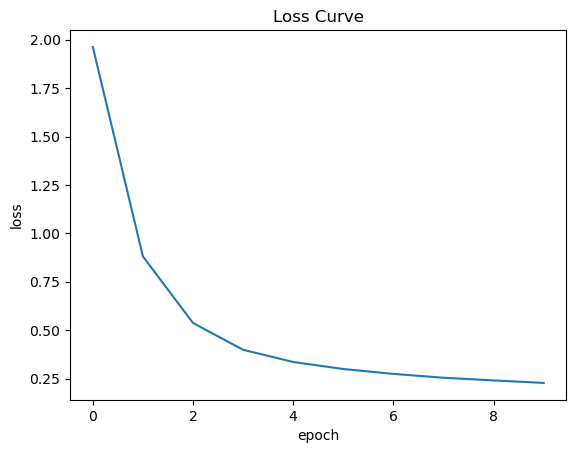

In [310]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

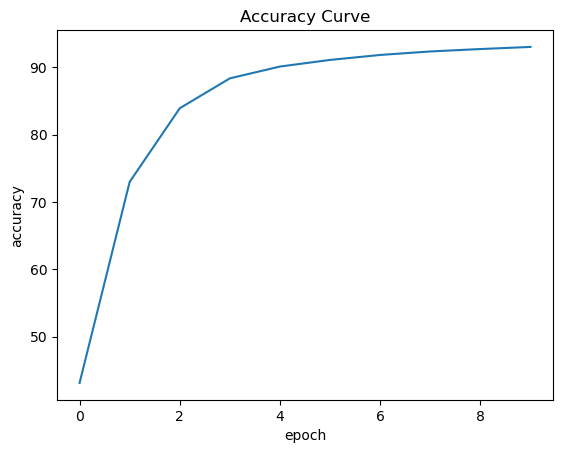

In [311]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')

In [312]:
evaluate(model, test_loader)

100%|██████████| 132/132 [00:04<00:00, 31.15it/s]

Test Accuracy: 85.917
Top 5 Test Accuracy: 98.226


(85.91691394658754, 98.22551928783383)

In [313]:
def predict_input(model, text, speaker_id, target_label, is_text_encoded=False):

    print("-------------------")
    if not is_text_encoded:
        _, cleaned_text = clean_utterances([{'utterance': text, 'speaker': 'USER' if speaker_id == [1, 0] else 'SYSTEM'}])
        encoded_test_sentence = encode_text(cleaned_text, max_len = 100)
        print(' '.join([rev_word_map[w] for w in encoded_test_sentence[0]]))
        encoded_test_sentence = torch.tensor(encoded_test_sentence)
    else:
        sentence = ' '.join([rev_word_map[w] for w in text.tolist()])
        print(sentence)
        encoded_test_sentence = text.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        output = model(encoded_test_sentence.to(device), speaker_id.to(device))
        prob, pred = F.softmax(output, dim = -1).max(1)
    print('index {} ({}) is predicted with a probability of {}'.format(pred.item(), inv_acts_labels[pred.item()], prob.item()))
    print('True label is {}'.format(inv_acts_labels[target_label]))

    all_probs = F.softmax(output, dim = -1)

    predictions_with_probs = [(inv_acts_labels[i], p.item()) for i, p in enumerate(all_probs[0])]
    # for pred, prob in predictions_with_probs:
    #     print(f"{pred}: {prob:.3f}")

    
    # Top 5 predictions and top 5 accuracy
    top_5_preds = all_probs.topk(5)
    top_5_preds_indices = top_5_preds.indices[0]
    top_5_preds_probs = top_5_preds.values[0]
    top_5_preds_with_probs = [(inv_acts_labels[i.item()], p.item()) for i, p in zip(top_5_preds_indices, top_5_preds_probs)]

    print("Top 5 predictions with probabilities:")
    for pred, prob in top_5_preds_with_probs:
        print(f"{pred}: {prob:.3f}")
        
    return output, prob, pred

In [314]:
sample, speaker_id, target = test_dataset[0]
target = target.item()
speaker_id = speaker_id.unsqueeze(0)  # Add this line to make speaker_id a 2D tensor
output, prob, pred = predict_input(model, text=sample, speaker_id=speaker_id, target_label=target, is_text_encoded=True)

-------------------
<start> hi could you get me a restaurant booking on the 8th please ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
index 34 (USER_INFORM|USER_INFORM_INTENT) is predicted with a probability of 0.9750328063964844
True label is USER_INFORM|USER_INFORM_INTENT
Top 5 predictions with probabilities:
USER_INFORM|USER_INFORM_INTENT: 0.975
USER_INFORM|USER_INFORM_INTENT|USER_SELECT: 0.009
USER_INFORM_INTENT: 0.007
USER_INFORM|USER_REQUEST_ALTS: 0.006
USER_INFORM: 0.002


In [315]:
test_sentence = "No problem, goodbye!"
test_speaker_id = torch.tensor([0, 1]).unsqueeze(0)  # [0, 1] for SYSTEM, [1, 0] for USER
test_target = 5 # 5 is the index of the "SYSTEM_GOODBYE" act
_ = predict_input(model, text=test_sentence, speaker_id=test_speaker_id, target_label=test_target)

-------------------
<start> no problem goodbye <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
index 35 (SYSTEM_INFORM) is predicted with a probability of 0.782960832118988
True label is SYSTEM_GOODBYE
Top 5 predictions with probabilities:
SYSTEM_INFORM: 0.783
SYSTEM_REQ_MORE: 0.201
SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE: 0.005
USER_NEGATE|USER_THANK_YOU: 0.004
USER_NEGATE: 0.002


### Implementation 2: Paper - "A Context-based Approach for Dialogue Act Recognition using Simple Recurrent Neural Networks"

In [3]:
import torch
from torch.autograd import Variable
# from models import mLSTM, StackedLSTM

# Load the pretrained model checkpoint
checkpoint = torch.load('mlstm-ns.pt', map_location='cpu')

# Extract model components
encoder = checkpoint['rnn']  # This is the trained mLSTM model
embed = checkpoint['embed']  # Character embedding layer

encoder.eval()  # Set the model to evaluation mode

C:\Users\Ward\AppData\Local\Temp\ipykernel_14960\3209141506.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mlstm-ns.pt', map_location='cpu')


StackedLSTM(
  (dropout): Dropout(p=0.0, inplace=False)
  (h2o): Linear(in_features=4096, out_features=256, bias=True)
  (layer_0): mLSTM(
    (wx): Linear(in_features=128, out_features=16384, bias=False)
    (wh): Linear(in_features=4096, out_features=16384, bias=True)
    (wmx): Linear(in_features=128, out_features=4096, bias=False)
    (wmh): Linear(in_features=4096, out_features=4096, bias=False)
  )
)

In [ ]:
def extract_feature_vectors(sentence, embed, rnn, type="last"):
    rnn.eval()
    with torch.no_grad():
        sentence_tensor = torch.LongTensor([ord(c) for c in sentence]).unsqueeze(1)  # Shape: (seq_len, 1)
        hidden_state = rnn.state0(batch_size=1)
        hidden_states = []  # Store all hidden states
        
        for char in sentence_tensor:
            char_var = Variable(char)
            emb = embed(char_var)
            hidden_state, _ = rnn(emb, hidden_state)
            hidden_states.append(hidden_state[0].detach().cpu())  # Extract h_t (first element of tuple)

        # Last hidden state
        last_feature_vector = hidden_states[-1].squeeze()

        # Average hidden state
        avg_feature_vector = torch.mean(torch.stack(hidden_states), dim=0).squeeze()

        return last_feature_vector if type == "last" else avg_feature_vector


In [30]:
sentence = "Hello, how are you?"
last_vec = extract_feature_vectors(sentence, embed, encoder, type="last")
avg_vec = extract_feature_vectors(sentence, embed, encoder, type="average")

print("Last Feature Vector Shape:", last_vec.shape)
print("Average Feature Vector Shape:", avg_vec.shape)

Last Feature Vector Shape: torch.Size([4096])
Average Feature Vector Shape: torch.Size([4096])


In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

class DialogueWindowDataset(Dataset):
    def __init__(self, embeddings_path, file_path):
        # Load precomputed embeddings
        self.embeddings = torch.load(embeddings_path)
        
        with open(file_path, 'r') as f:
            file_contents = json.load(f)
            dialogues = [dialogue['turns'] for dialogue in file_contents]
            self.data = []
            for dialog_idx, dialog in enumerate(tqdm(dialogues)):
                embeddings = self.embeddings[dialog_idx]
                speakers = [turn['speaker'] for turn in dialog]
                speakers = [0 if spk == 'USER' else 1 for spk in speakers]
                labels = [acts_labels[turn['dialogue_act']] for turn in dialog]
                
                n = len(embeddings)
                for t in range(n):
                    # Collect previous two utterances and current (indices t-2, t-1, t)
                    window_emb = []
                    window_speaker = []
                    for idx in [t-2, t-1, t]:
                        if idx >= 0:
                            emb = embeddings[idx]
                            spk = torch.nn.functional.one_hot(
                                torch.tensor(speakers[idx]), num_classes=2
                            ).float()
                        else:
                            emb = torch.zeros(4096)  # Embedding dimension
                            spk = torch.zeros(2)
                        window_emb.append(emb)
                        window_speaker.append(spk)
                    
                    window_emb = torch.stack(window_emb)  # (3, embed_dim)
                    window_speaker = torch.stack(window_speaker)  # (3, 2)
                    combined = torch.cat([window_emb, window_speaker], dim=1)  # (3, embed_dim + 2)
                    label = labels[t]
                    
                    self.data.append((combined, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [44]:
# Define the dataset and dataloader
train_dataset = DialogueWindowDataset(embeddings_path='train_embeddings_average.pt', file_path=path_to_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = DialogueWindowDataset(embeddings_path='test_embeddings_average.pt', file_path=path_to_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Example batch
for batch in train_loader:
    combined, labels = batch
    print(combined.shape)  # (batch_size, 3, embed_dim + 2)
    print(labels.shape)    # (batch_size,)
    break

C:\Users\Ward\AppData\Local\Temp\ipykernel_14960\263095399.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████|

torch.Size([128, 3, 4098])
torch.Size([128])


In [51]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, pooling_type='last_hidden_state'):
        super().__init__()
        # self.rnn = RNN(input_size, hidden_size)  # Uncomment for RNN
        self.lstm = LSTM(input_size, hidden_size)  # Use LSTM by default
        self.classifier = nn.Linear(hidden_size, num_classes)  # Output layer
        self.pooling_type = pooling_type

    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_size)
        # Pass through the RNN/LSTM
        x = self.lstm(x)  # (batch_size, seq_len, hidden_size)

        # Pooling
        if self.pooling_type == "last_hidden_state":
            x = x[:, -1, :]  # (batch_size, hidden_size)
        else:
            x = x.mean(dim=1)  # (batch_size, hidden_size)

        # Classify
        x = self.classifier(x)  # (batch_size, num_classes)
        return x

In [52]:
def train(model, optimizer, criterion, epoch, num_epochs, train_loader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (combined, labels) in enumerate(tqdm(train_loader)):
        # Move to device
        combined = combined.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(combined)  # (batch_size, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss / (batch_idx + 1)
    epoch_acc = 100. * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.3f}, Train Accuracy: {epoch_acc:.3f}')
    return epoch_loss, epoch_acc

In [53]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for combined, labels in tqdm(test_loader):
            combined = combined.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(combined)  # (batch_size, num_classes)

            # Top-1 accuracy
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

            # Top-5 accuracy
            _, top5_predicted = outputs.topk(5, 1, True, True)
            target_reshaped = labels.view(-1, 1).expand_as(top5_predicted)
            top5_correct += top5_predicted.eq(target_reshaped).sum().item()

            total += labels.size(0)

    acc = 100. * correct / total
    top5_acc = 100. * top5_correct / total
    print(f'Test Accuracy: {acc:.3f}')
    print(f'Top 5 Test Accuracy: {top5_acc:.3f}')
    return acc, top5_acc

In [54]:
# Hyperparameters
input_size = 4096 + 2  # Embedding dimension + speaker one-hot
hidden_size = 32
num_classes = len(acts_labels)  # Number of dialogue acts
pooling_type = 'average'  # 'last_hidden_state' or 'average'

# Initialize model, optimizer, and criterion
model = Net(input_size, hidden_size, num_classes, pooling_type).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_loss, epoch_acc = train(model, optimizer, criterion, epoch, num_epochs, train_loader)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

# Evaluate on the test set
test_acc, test_top5_acc = evaluate(model, test_loader)

100%|██████████| 646/646 [00:05<00:00, 121.35it/s]


Epoch 1/10, Train Loss: 0.787, Train Accuracy: 80.136


100%|██████████| 646/646 [00:04<00:00, 130.88it/s]


Epoch 2/10, Train Loss: 0.162, Train Accuracy: 96.215


100%|██████████| 646/646 [00:04<00:00, 131.06it/s]


Epoch 3/10, Train Loss: 0.092, Train Accuracy: 97.777


100%|██████████| 646/646 [00:04<00:00, 130.53it/s]


Epoch 4/10, Train Loss: 0.068, Train Accuracy: 98.265


100%|██████████| 646/646 [00:04<00:00, 129.88it/s]


Epoch 5/10, Train Loss: 0.052, Train Accuracy: 98.638


100%|██████████| 646/646 [00:05<00:00, 128.79it/s]


Epoch 6/10, Train Loss: 0.041, Train Accuracy: 98.916


100%|██████████| 646/646 [00:04<00:00, 130.60it/s]


Epoch 7/10, Train Loss: 0.037, Train Accuracy: 99.020


100%|██████████| 646/646 [00:04<00:00, 135.34it/s]


Epoch 8/10, Train Loss: 0.032, Train Accuracy: 99.094


100%|██████████| 646/646 [00:04<00:00, 133.44it/s]


Epoch 9/10, Train Loss: 0.028, Train Accuracy: 99.217


100%|██████████| 646/646 [00:04<00:00, 129.81it/s]


Epoch 10/10, Train Loss: 0.023, Train Accuracy: 99.362


100%|██████████| 132/132 [00:00<00:00, 223.36it/s]

Test Accuracy: 94.896
Top 5 Test Accuracy: 99.662
